<a href="https://colab.research.google.com/github/O-suke12/Semantic_Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from PIL import Image
import os
from google.colab import files

if torch.cuda.is_available(): 
 dev = "cuda:0" 
else: 
  dev = "cpu" 
dev

'cpu'

# **Reference**





Dataset: https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset?sort=votes

# **Dataset**

In [2]:
if os.path.exists("kaggle.json"):
  print("already exist")
else:
  uploaded = files.upload()
  ! mkdir ~/.kaggle
  ! cp kaggle.json ~/.kaggle/
  ! chmod 600 ~/.kaggle/kaggle.json
  ! kaggle datasets download -d bulentsiyah/semantic-drone-dataset
  ! unzip  semantic-drone-dataset

Saving kaggle.json to kaggle.json
100% 3.88G/3.89G [00:45<00:00, 101MB/s] 
100% 3.89G/3.89G [00:45<00:00, 92.5MB/s]
Archive:  semantic-drone-dataset.zip
  inflating: RGB_color_image_masks/RGB_color_image_masks/000.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/001.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/002.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/003.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/004.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/005.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/006.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/008.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/011.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/013.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/014.png  
  inflating: RGB_color_image_masks/RGB_color_image_masks/015.png  
  inflating: RGB_color_image_masks/RGB_colo

In [3]:
df_class = pd.read_csv("/content/class_dict_seg.csv")
df_class.head()

,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87


In [4]:
import os
from sklearn.model_selection import train_test_split

dict = {"Name":[]}
df = pd.DataFrame(dict)
df = pd.DataFrame(os.listdir("/content/RGB_color_image_masks/RGB_color_image_masks"))
df_train, df_valid = train_test_split(df, test_size=0.2, random_state=42)

In [65]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from  torchvision import transforms
from torch.utils.data.dataloader import DataLoader

preprocess = transforms.Compose([
    transforms.Resize(size=(400,600)),
    transforms.ConvertImageDtype(torch.float),
])

class Custom_dataset(Dataset):
  def __init__(self, image_dir, label_dir, mask_dir, df, transform=True):
    self.df = df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self,idx):
    image = read_image(image_dir+"/"+self.df.iloc[idx,0][:-3]+"jpg")
    label = read_image(label_dir+"/"+self.df.iloc[idx,0])
    mask = read_image(mask_dir+"/"+self.df.iloc[idx,0])
    image = self.transform(image)
    label = self.transform(label)
    mask = self.transform(mask)
    return image, mask, label

image_dir = "/content/dataset/semantic_drone_dataset/original_images"
label_dir = "/content/RGB_color_image_masks/RGB_color_image_masks"
mask_dir = "/content/dataset/semantic_drone_dataset/label_images_semantic"

CD_train = Custom_dataset(image_dir, label_dir, mask_dir, df_train, preprocess)
CD_valid = Custom_dataset(image_dir, label_dir, mask_dir, df_valid, preprocess)
train_loader = DataLoader(CD_train, batch_size=32, shuffle=True, num_workers=2, drop_last=True)
valid_loader = DataLoader(CD_valid, batch_size=32, shuffle=True, num_workers=2, drop_last=True)

# **Model**

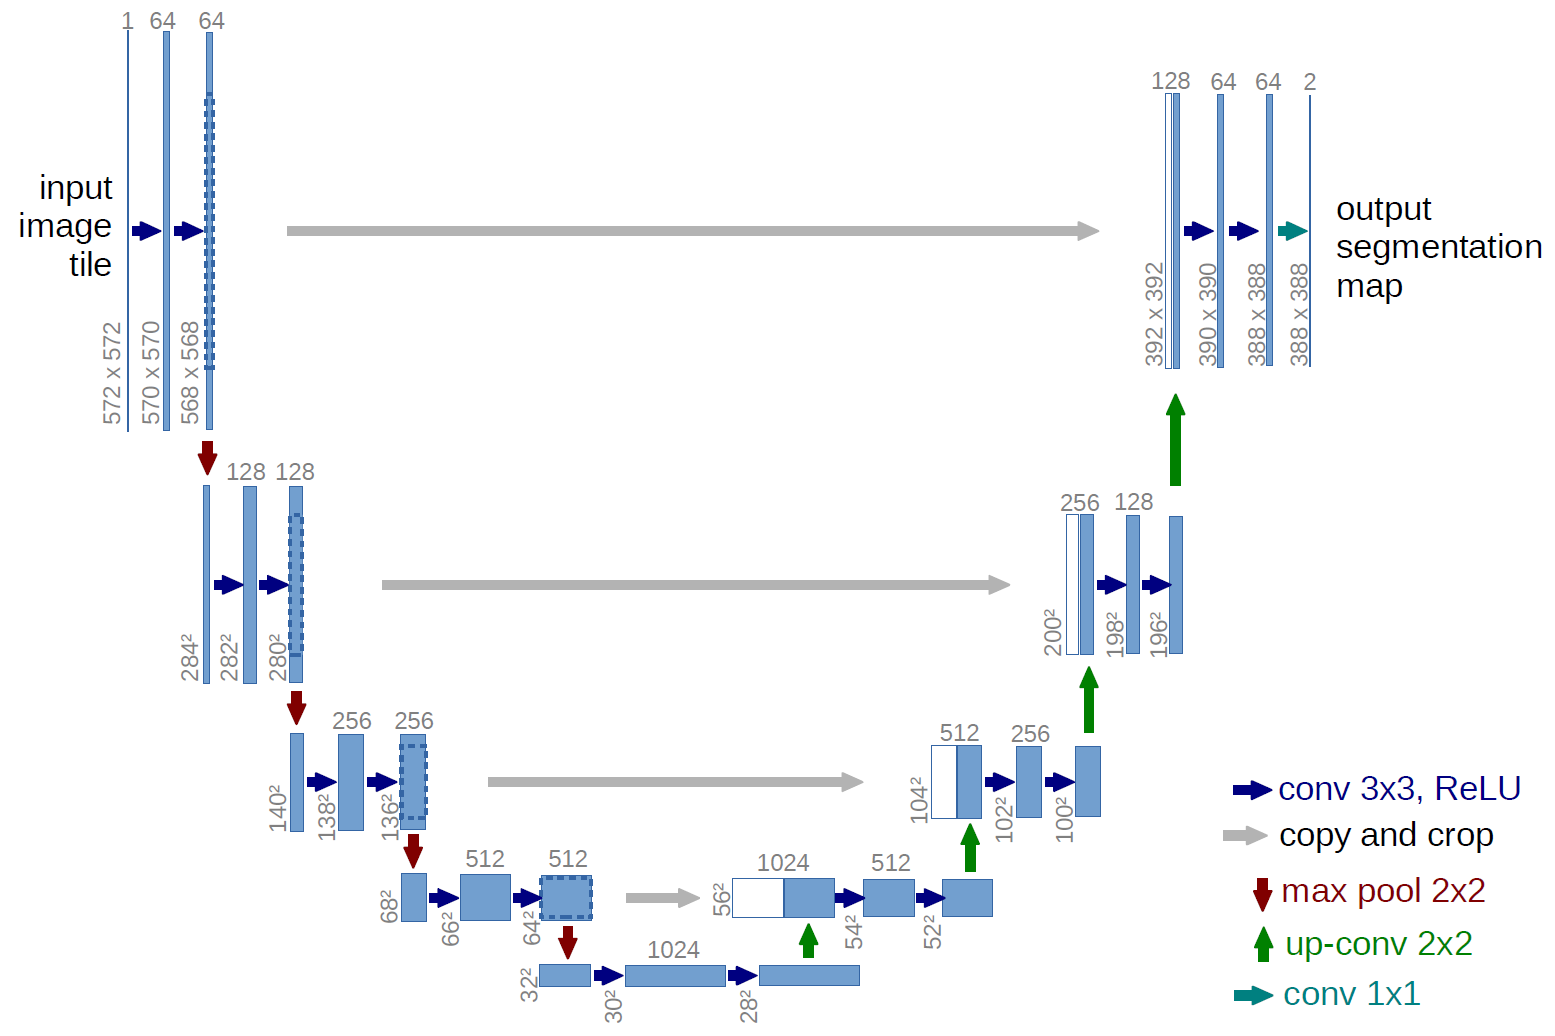![image.png](
  
)

In [59]:
from torchvision.transforms.functional import resize

class double_conv(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.conv_block = nn.Sequential(
        nn.Conv2d(in_features, out_features, 3, padding=1),
        nn.BatchNorm2d(out_features),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_features, out_features, 3, padding=1),
        nn.BatchNorm2d(out_features),
        nn.ReLU(inplace=True),
    )
    
  def forward(self,X):
    return  self.conv_block(X)

class UNET(nn.Module):
  def __init__(self,):
    super().__init__()
    self.encode1 = nn.Sequential(
        double_conv(1, 64),
    )
    self.encode2 = nn.Sequential(
        nn.MaxPool2d(2,2),
        double_conv(64, 128),
    )
    self.encode3 = nn.Sequential(
        nn.MaxPool2d(2,2),
        double_conv(128, 256),
    )
    self.encode4 = nn.Sequential(
        nn.MaxPool2d(2,2),
        double_conv(256, 512),
    )
    self.bottleneck = nn.Sequential(
        nn.MaxPool2d(2,2),
        double_conv(512, 1024),
    )

    self.decode1 = nn.Sequential(
        nn.ConvTranspose2d(1024,512,2,2),
    )

    self.decode2 = nn.Sequential(
        double_conv(1024, 512),
        nn.ConvTranspose2d(512,256,2,2),
    )

    self.decode3 = nn.Sequential(
        double_conv(512, 256),
        nn.ConvTranspose2d(256,128,2,2),
    )

    self.decode4 = nn.Sequential(
        double_conv(256,128),
        nn.ConvTranspose2d(128,64,2,2),
    )

    self.last_conv = nn.Sequential(
        double_conv(128,64),
        nn.Conv2d(64,1,kernel_size=1)
    )
  
  def forward(self,X):
    u1 = X = self.encode1(X)
    u2 = X = self.encode2(X)
    u3 = X = self.encode3(X)
    u4 = X = self.encode4(X)

    X = self.bottleneck(X)

    X = self.decode1(X)
    X = resize(X, u4.shape[2:])
    X = self.decode2(torch.cat((u4,X),dim=1))
    X = resize(X, u3.shape[2:])
    X = self.decode3(torch.cat((u3,X),dim=1))
    X = resize(X, u2.shape[2:])
    X = self.decode4(torch.cat((u2,X),dim=1))
    X = resize(X, u1.shape[2:])
    return self.last_conv(torch.cat((u1,X),dim=1))

sample_X = CD_train.__getitem__(0)[2].unsqueeze(0)
model = UNET()
model = model.to(torch.device(dev))

# **Train and Evaluation**

In [70]:
epochs = 10
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

from tqdm import tqdm 

for epoch in range(epochs):
  train_loss = 0  
  for batch, mask, label in tqdm(train_loader):
    model.train()
    batch = batch.to(torch.device(dev))
    mask = mask.to(torch.device(dev))
    y_pred = model(mask)


  0%|          | 0/10 [00:51<?, ?it/s]


KeyboardInterrupt: ignored